In [1]:
import pandas as pd
import os
import warnings
import numpy as np
warnings.filterwarnings("ignore")
your_path = 'F:\\home-credit-default-risk'
pos_cash_balance = pd.read_csv(f'{your_path}\\POS_CASH_balance.csv')
pos_cash_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [2]:
numeric_features = []
categorical_features = []

# 遍历每列来确定其数据类型
for column in pos_cash_balance.columns:
    if pos_cash_balance[column].dtype == 'object':
        # pandas将非数值列识别为object类型，通常对应离散型特征
        categorical_features.append(column)
    else:
        # 其余的视为数值型特征
        numeric_features.append(column)
categorical_features

['NAME_CONTRACT_STATUS']

In [3]:
application_train = pd.read_csv(f'{your_path}\\application_train.csv')
target_cols = application_train[['SK_ID_CURR','TARGET']]
pos_cash_balance = pd.merge(pos_cash_balance, target_cols, on='SK_ID_CURR', how='right')
pos_cash_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,TARGET
0,1038818.0,100002,-13.0,24.0,18.0,Active,0.0,0.0,1
1,1038818.0,100002,-16.0,24.0,21.0,Active,0.0,0.0,1
2,1038818.0,100002,-18.0,24.0,23.0,Active,0.0,0.0,1
3,1038818.0,100002,-17.0,24.0,22.0,Active,0.0,0.0,1
4,1038818.0,100002,-5.0,24.0,10.0,Active,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
8561437,1743609.0,456255,-28.0,12.0,7.0,Active,0.0,0.0,0
8561438,1743609.0,456255,-32.0,12.0,11.0,Active,0.0,0.0,0
8561439,1359084.0,456255,-10.0,12.0,7.0,Active,0.0,0.0,0
8561440,1743609.0,456255,-25.0,12.0,4.0,Active,5.0,5.0,0


In [4]:
def calculate_woe_iv(df, feature, target):
    # 构造交叉表
    df_cross = pd.crosstab(df[feature], df[target])
    # 计算每个分组的事件和非事件总数
    df_cross['Total'] = df_cross.sum(axis=1)
    df_cross['Event Rate'] = df_cross[1] / df_cross['Total']
    df_cross['Non-Event Rate'] = df_cross[0] / df_cross['Total']

    # 避免除以零，添加一个小数
    df_cross['Event Distribution'] = df_cross[1] / df_cross[1].sum()
    df_cross['Non-Event Distribution'] = df_cross[0] / df_cross[0].sum()
    df_cross['WoE'] = np.log((df_cross['Event Distribution'] + 0.0001) / (df_cross['Non-Event Distribution'] + 0.0001))

    # 计算IV
    df_cross['IV'] = (df_cross['Event Distribution'] - df_cross['Non-Event Distribution']) * df_cross['WoE']

    # 返回IV值
    iv = df_cross['IV'].sum()
    return iv

# 对每个在 string_columns 中的变量计算 IV
iv_values = {col: calculate_woe_iv(pos_cash_balance, col, 'TARGET') for col in categorical_features}

# 创建 DataFrame 并按 IV 值排序
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Feature', 'Information Value'])
iv_df = iv_df.sort_values(by='Information Value', ascending=False)
iv_df

,Feature,Information Value
0,NAME_CONTRACT_STATUS,0.000626


In [5]:
pos_cash_balance.drop(['NAME_CONTRACT_STATUS'],inplace=True,axis=1)
pos_cash_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,TARGET
0,1038818.0,100002,-13.0,24.0,18.0,0.0,0.0,1
1,1038818.0,100002,-16.0,24.0,21.0,0.0,0.0,1
2,1038818.0,100002,-18.0,24.0,23.0,0.0,0.0,1
3,1038818.0,100002,-17.0,24.0,22.0,0.0,0.0,1
4,1038818.0,100002,-5.0,24.0,10.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
8561437,1743609.0,456255,-28.0,12.0,7.0,0.0,0.0,0
8561438,1743609.0,456255,-32.0,12.0,11.0,0.0,0.0,0
8561439,1359084.0,456255,-10.0,12.0,7.0,0.0,0.0,0
8561440,1743609.0,456255,-25.0,12.0,4.0,5.0,5.0,0


In [6]:
from datetime import timedelta

# Define the aggregation functions
aggregations = {
    'max': 'max',
    'min': 'min',
    'mean': 'mean',
    'var': 'var',
    'sum':'sum',
    'count':'count'
    
}

# Define the time windows in terms of MONTHS_BALANCE
time_windows = {
    '3_months': (-2, 0),
    '6_months': (-5, 0),
    '9_months': (-8, 0),
    'all_time': (pos_cash_balance['MONTHS_BALANCE'].min(), 0)
}

# Initialize an empty DataFrame to store results
result_df = pd.DataFrame()

# Loop through each time window and perform aggregations
for window_name, (start, end) in time_windows.items():
    # Filter data for the time window
    mask = (pos_cash_balance['MONTHS_BALANCE'] >= start) & (pos_cash_balance['MONTHS_BALANCE'] <= end)
    filtered_data = pos_cash_balance.loc[mask]
    
    # Define which columns to aggregate and how
    agg_dict = {col: ['max', 'min', 'mean', 'var','sum','count'] for col in filtered_data.columns if col not in ['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE']}
    
    # Aggregate data
    agg_data = filtered_data.groupby(['SK_ID_CURR']).agg(agg_dict)
    
    # Flatten multi-level column names
    agg_data.columns = [f"{window_name}_{col}_{stat}" for col, stat in agg_data.columns]
    
    # Join the aggregated data back to the results dataframe
    if result_df.empty:
        result_df = agg_data.reset_index()
    else:
        result_df = result_df.merge(agg_data.reset_index(), on=['SK_ID_CURR'], how='outer')

# Display a sample of the final aggregated DataFrame
result_df


,SK_ID_CURR,3_months_CNT_INSTALMENT_max,3_months_CNT_INSTALMENT_min,3_months_CNT_INSTALMENT_mean,3_months_CNT_INSTALMENT_var,3_months_CNT_INSTALMENT_sum,3_months_CNT_INSTALMENT_count,3_months_CNT_INSTALMENT_FUTURE_max,3_months_CNT_INSTALMENT_FUTURE_min,3_months_CNT_INSTALMENT_FUTURE_mean,...,all_time_SK_DPD_DEF_mean,all_time_SK_DPD_DEF_var,all_time_SK_DPD_DEF_sum,all_time_SK_DPD_DEF_count,all_time_TARGET_max,all_time_TARGET_min,all_time_TARGET_mean,all_time_TARGET_var,all_time_TARGET_sum,all_time_TARGET_count
0,100002,24.0,24.0,24.000000,0.000000,48.0,2.0,7.0,6.0,6.500000,...,0.000000,0.000000,0.0,19,1,1,1.0,0.0,19,19
1,100006,12.0,12.0,12.000000,0.000000,24.0,2.0,4.0,3.0,3.500000,...,0.000000,0.000000,0.0,21,0,0,0.0,0.0,0,21
2,100007,24.0,24.0,24.000000,0.000000,48.0,2.0,14.0,13.0,13.500000,...,0.000000,0.000000,0.0,66,0,0,0.0,0.0,0,66
3,100008,10.0,10.0,10.000000,NaN,10.0,1.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,83,0,0,0.0,0.0,0,83
4,100009,12.0,10.0,10.666667,1.333333,32.0,3.0,10.0,0.0,6.333333,...,0.000000,0.000000,0.0,64,0,0,0.0,0.0,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289439,456246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.0,7,0,0,0.0,0.0,0,7
289440,456247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.0,27,0,0,0.0,0.0,0,27
289441,456249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.0,13,0,0,0.0,0.0,0,13
289442,456252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.0,7,0,0,0.0,0.0,0,7


In [7]:
result_df = pd.merge(result_df, target_cols, on='SK_ID_CURR', how='right')

In [8]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import cross_val_score

# 假设final_df是你的DataFrame，TARGET是目标列名
X = result_df.drop(['TARGET','SK_ID_CURR'], axis=1)  # 特征数据
y = result_df['TARGET']  # 标签数据

# 创建LGBM模型
model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# 训练模型
model.fit(X, y)
accuracies = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f"Average Accuracy: {accuracies.mean()}")  # 打印平均准确率
print(f"Accuracy Standard Deviation: {accuracies.std()}") 
# 获取特征重要性
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

  # 打印特征重要性


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14835
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [11]:
importance_df.iloc[0:50]

,Feature,Importance
0,3_months_CNT_INSTALMENT_max,185
94,all_time_CNT_INSTALMENT_sum,101
114,all_time_TARGET_max,100
2,3_months_CNT_INSTALMENT_mean,87
1,3_months_CNT_INSTALMENT_min,82
3,3_months_CNT_INSTALMENT_var,72
4,3_months_CNT_INSTALMENT_sum,40
9,3_months_CNT_INSTALMENT_FUTURE_var,33
10,3_months_CNT_INSTALMENT_FUTURE_sum,29
8,3_months_CNT_INSTALMENT_FUTURE_mean,27


In [12]:
selected_features = list(pd.DataFrame(importance_df.iloc[0:32])['Feature'])
selected_features.append('SK_ID_CURR')
result_df[selected_features]

,3_months_CNT_INSTALMENT_max,all_time_CNT_INSTALMENT_sum,all_time_TARGET_max,3_months_CNT_INSTALMENT_mean,3_months_CNT_INSTALMENT_min,3_months_CNT_INSTALMENT_var,3_months_CNT_INSTALMENT_sum,3_months_CNT_INSTALMENT_FUTURE_var,3_months_CNT_INSTALMENT_FUTURE_sum,3_months_CNT_INSTALMENT_FUTURE_mean,...,3_months_CNT_INSTALMENT_FUTURE_min,6_months_CNT_INSTALMENT_FUTURE_var,6_months_CNT_INSTALMENT_FUTURE_sum,6_months_CNT_INSTALMENT_max,9_months_SK_DPD_mean,9_months_CNT_INSTALMENT_FUTURE_mean,all_time_SK_DPD_mean,3_months_SK_DPD_min,3_months_SK_DPD_max,SK_ID_CURR
0,24.0,456.0,1.0,24.0,24.0,0.000000,48.0,0.500000,13.0,6.5,...,6.0,2.500000,40.0,24.0,0.0,9.500000,0.000000,0.0,0.0,100002
1,NaN,283.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,100003
2,NaN,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,100004
3,12.0,240.0,0.0,12.0,12.0,0.000000,24.0,0.500000,7.0,3.5,...,3.0,7.619048,25.0,12.0,0.0,9.090909,0.000000,0.0,0.0,100006
4,24.0,1012.0,0.0,24.0,24.0,0.000000,48.0,0.500000,27.0,13.5,...,13.0,2.500000,75.0,24.0,0.0,16.500000,0.000000,0.0,0.0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,8.0,63.0,0.0,7.5,7.0,0.500000,15.0,2.000000,2.0,1.0,...,0.0,3.700000,14.0,8.0,0.0,4.375000,0.000000,0.0,0.0,456251
307507,NaN,42.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,456252
307508,NaN,114.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.294118,NaN,NaN,456253
307509,16.0,298.0,1.0,15.0,14.0,1.333333,60.0,5.666667,26.0,6.5,...,4.0,6.666667,80.0,16.0,0.0,9.500000,0.000000,0.0,0.0,456254


In [13]:
result_df[selected_features].to_csv('E://result//POS_CASH_balance.csv',index=False)

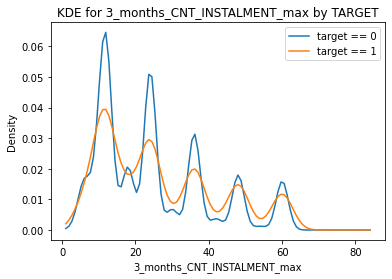

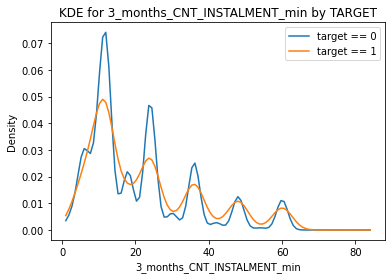

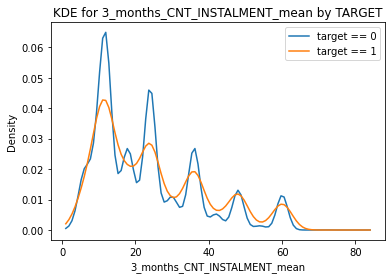

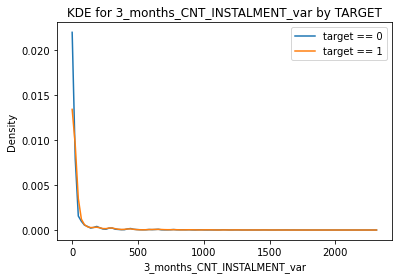

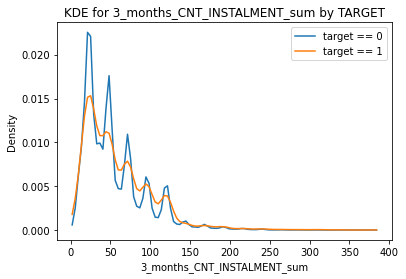

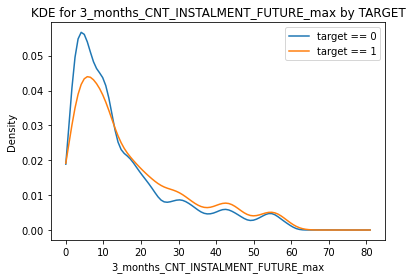

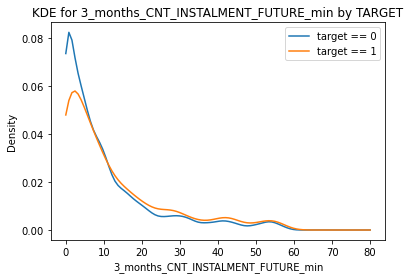

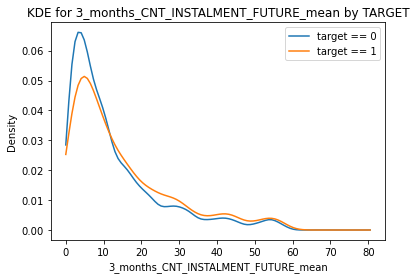

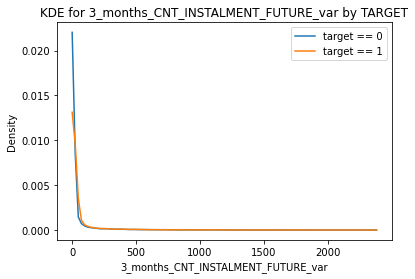

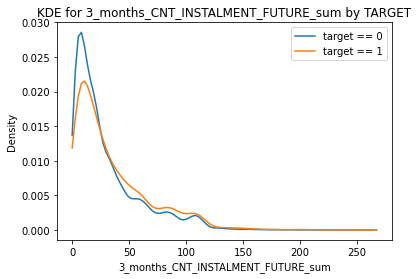

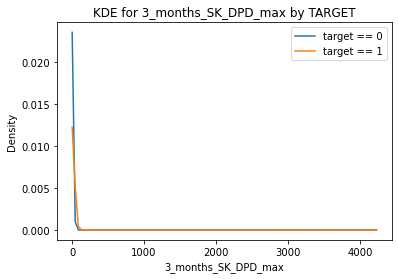

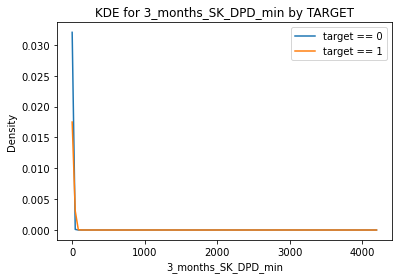

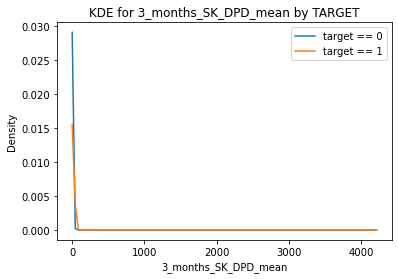

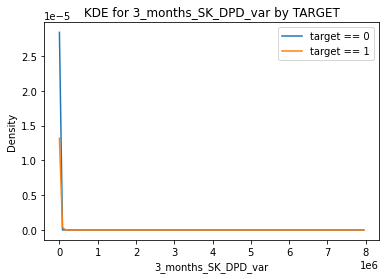

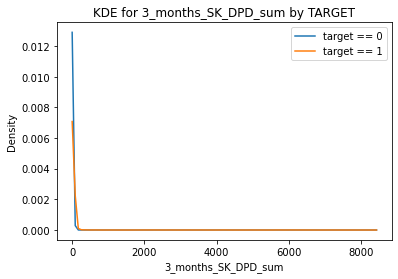

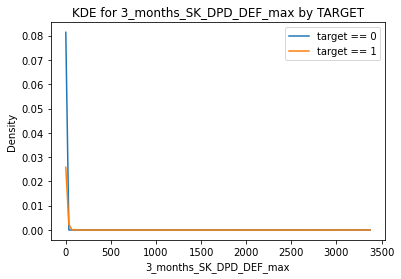

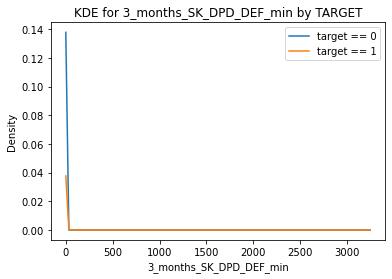

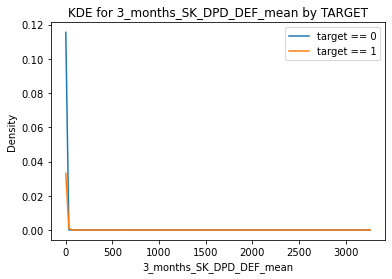

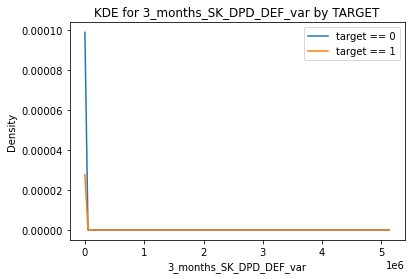

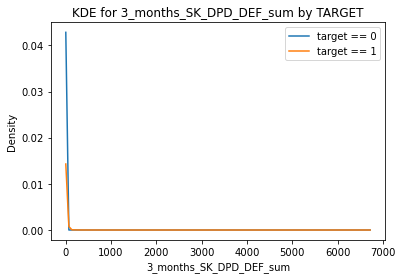

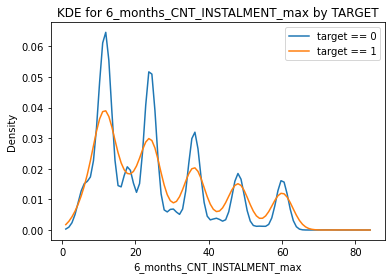

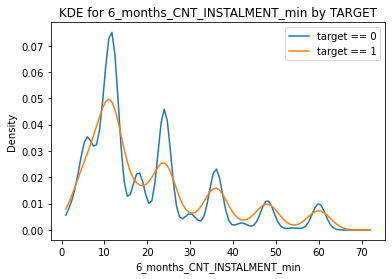

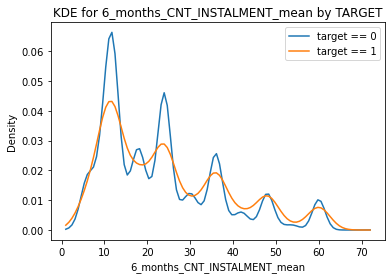

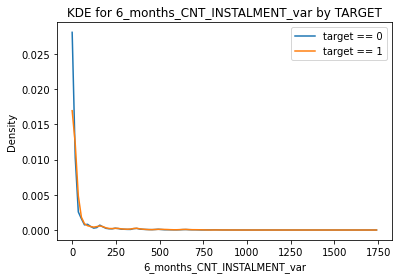

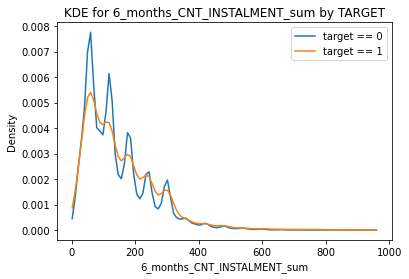

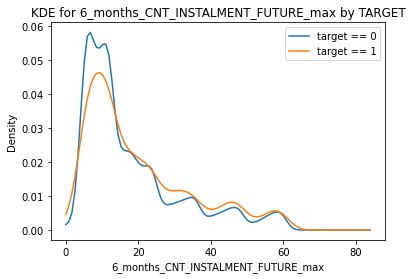

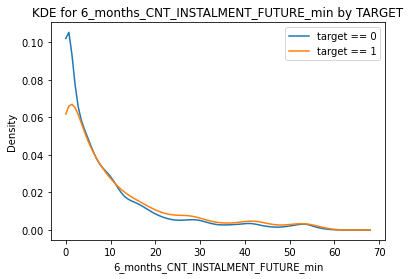

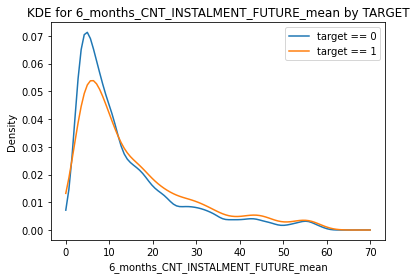

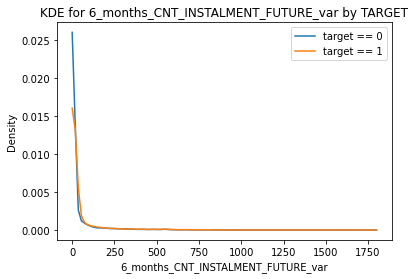

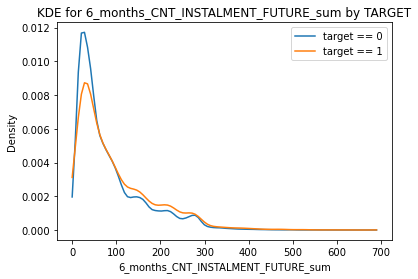

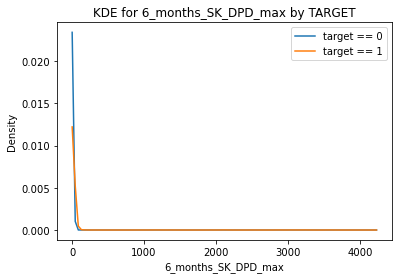

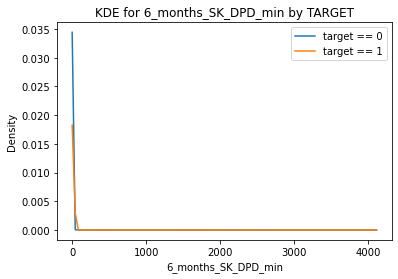

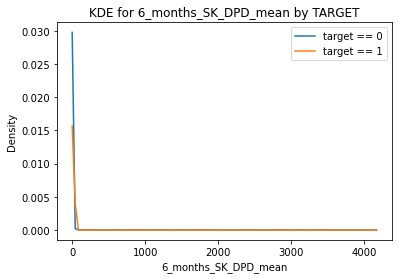

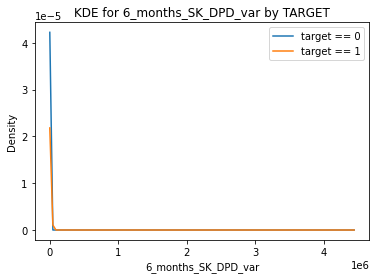

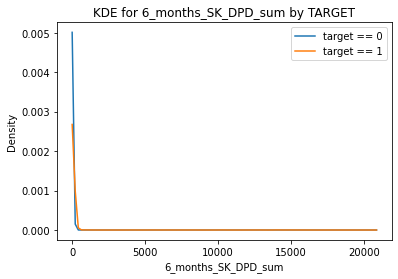

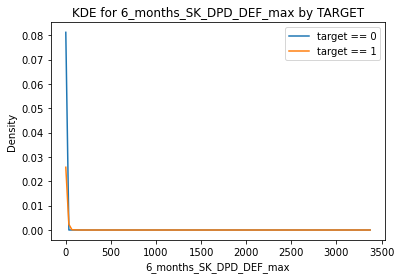

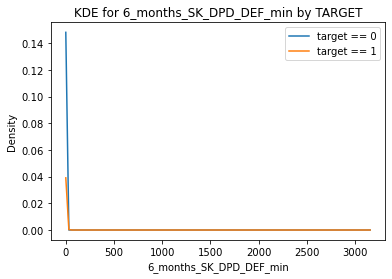

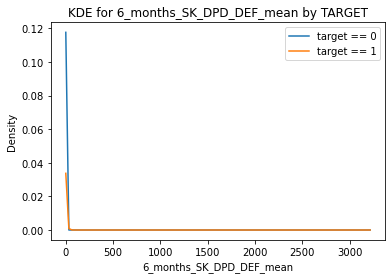

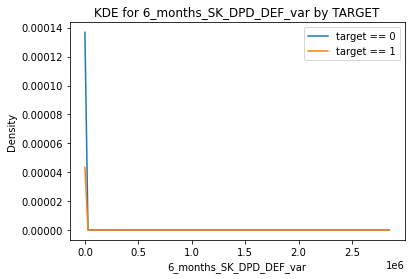

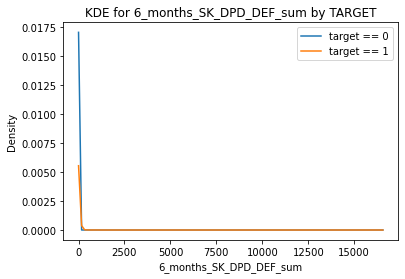

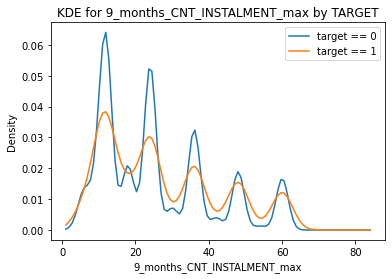

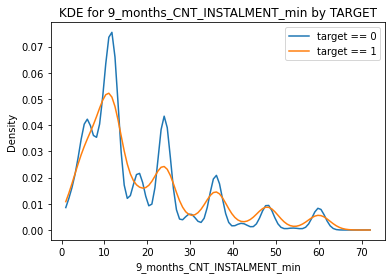

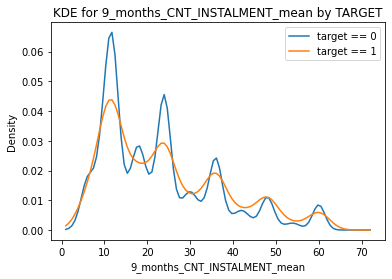

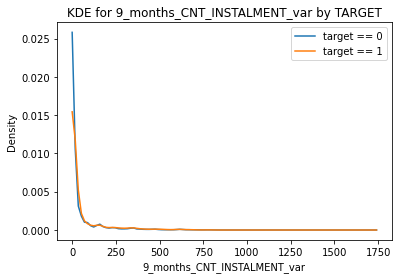

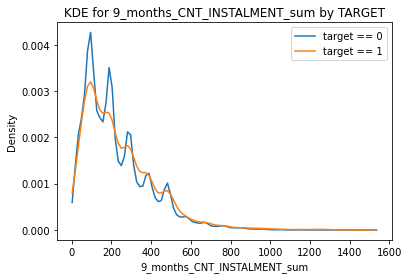

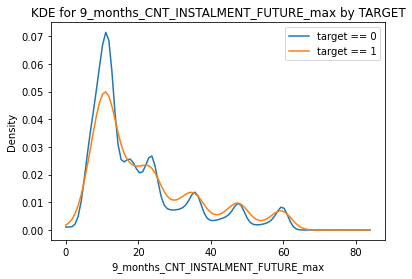

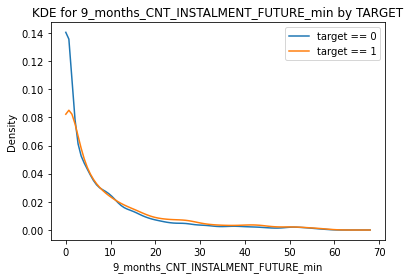

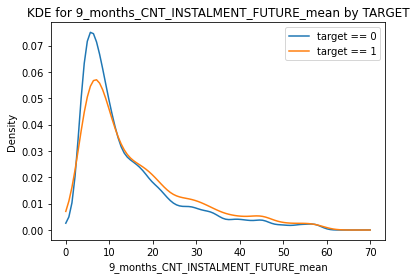

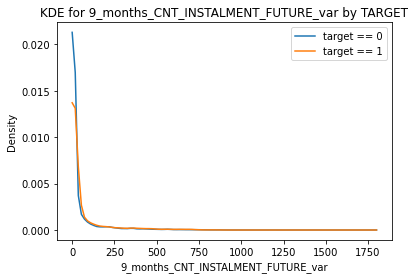

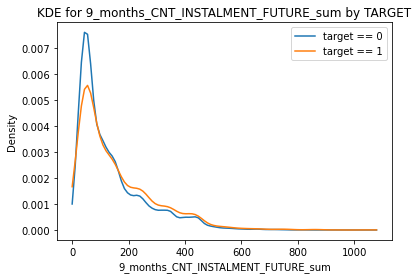

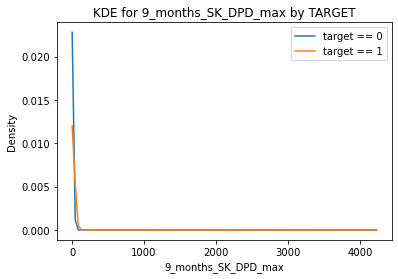

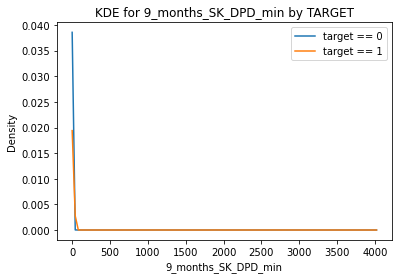

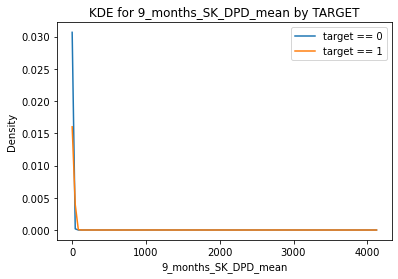

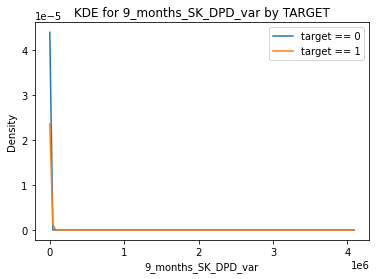

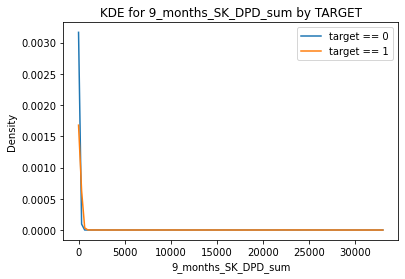

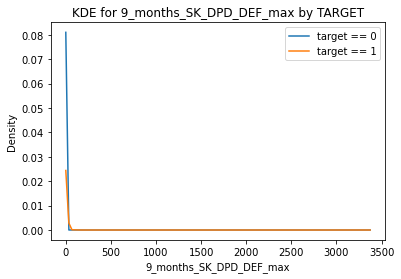

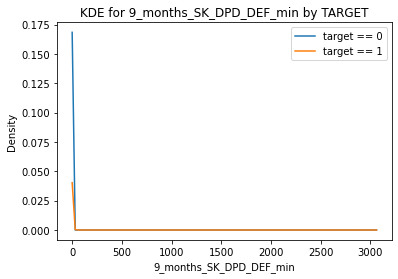

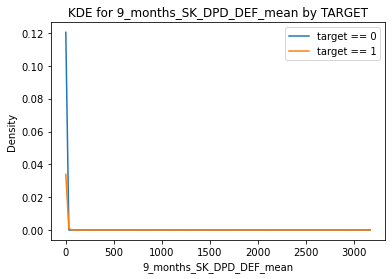

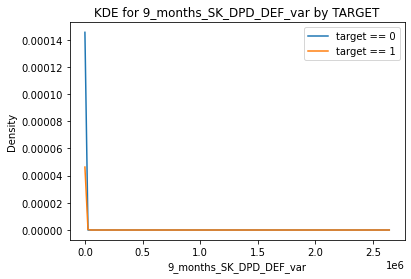

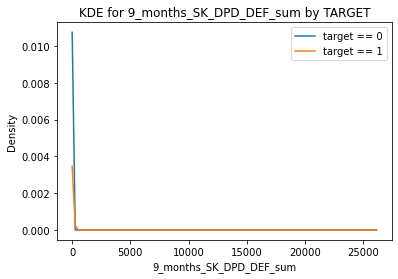

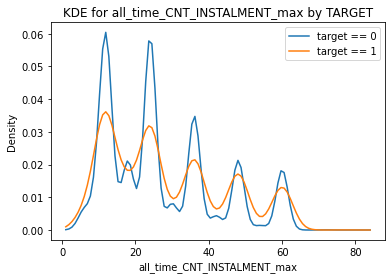

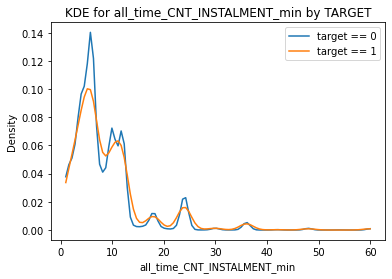

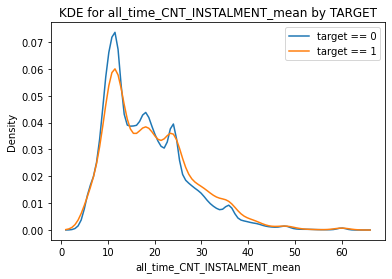

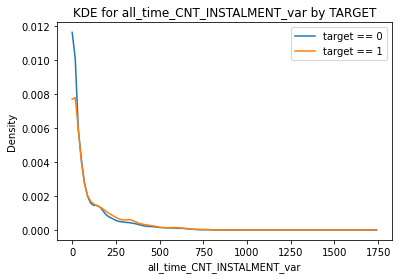

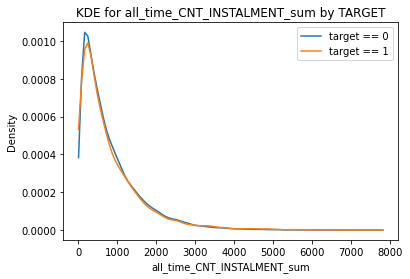

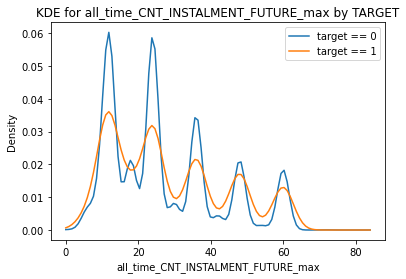

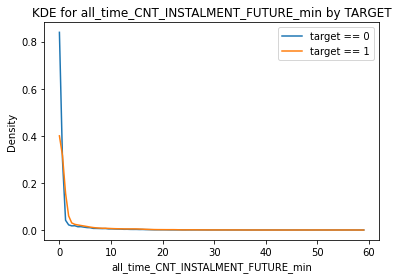

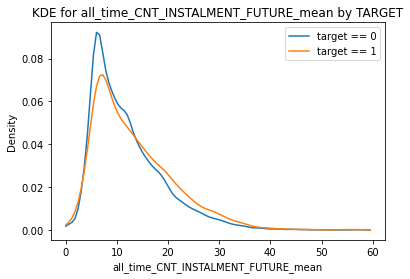

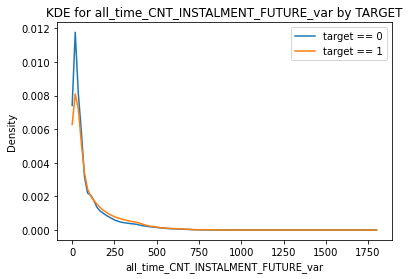

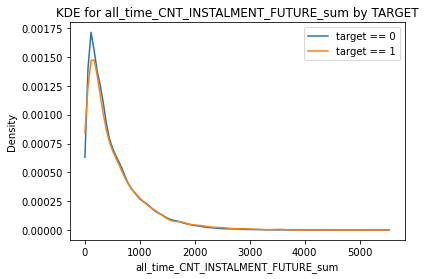

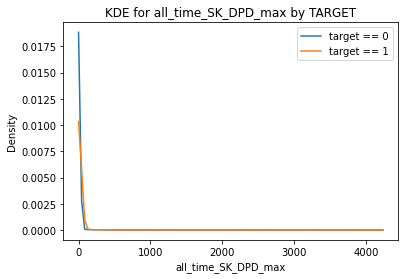

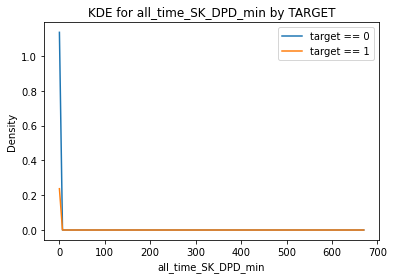

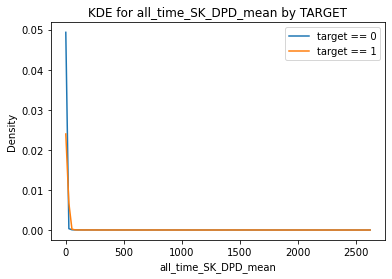

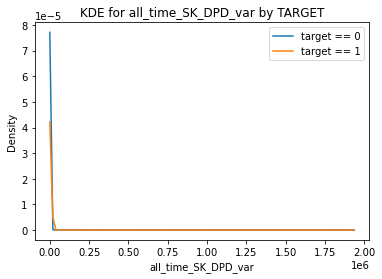

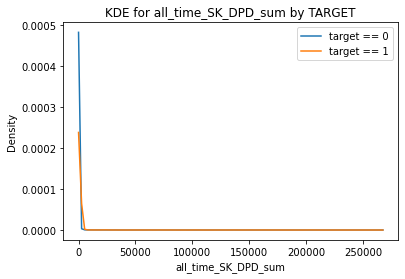

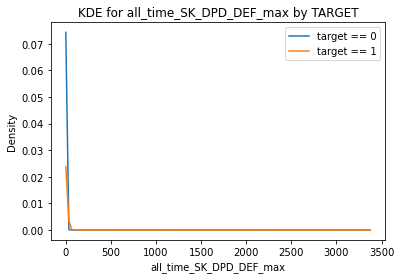

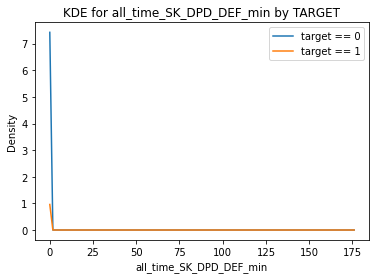

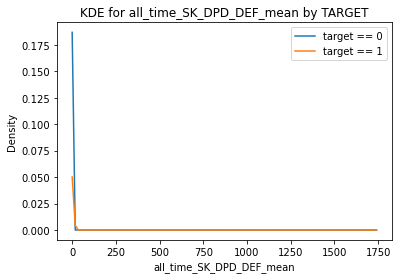

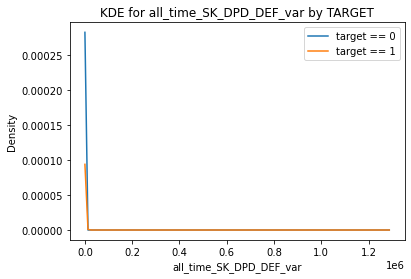

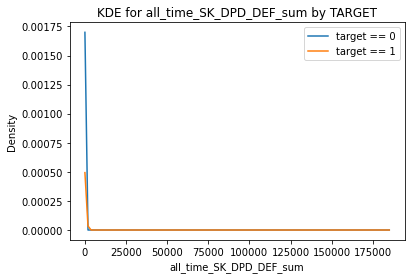

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# 在循环之前去除缺失值
final_df_clean = result_df.dropna()
# 设置绘图的大小

# 对于每个特征进行循环
for i, feature in enumerate(final_df_clean.columns[1:]):
    try:
        # 获取两个 TARGET 类别的数据
        data_0 = final_df_clean[final_df_clean['TARGET'] == 0][feature]
        data_1 = final_df_clean[final_df_clean['TARGET'] == 1][feature]

        # 计算每个类别的 KDE
        kde_0 = gaussian_kde(data_0)
        kde_1 = gaussian_kde(data_1)

        # 为 KDE 图形创建一个数值范围
        x_range = np.linspace(min(data_0.min(), data_1.min()), max(data_0.max(), data_1.max()), 100)

        # 绘制 KDE 图形
        plt.plot(x_range, kde_0(x_range), label='target == 0')
        plt.plot(x_range, kde_1(x_range), label='target == 1')

        # 设置标题和标签
        plt.title(f'KDE for {feature} by TARGET')
        plt.xlabel(feature)
        plt.ylabel('Density')

        # 显示图例
        plt.legend()
        plt.show()
    except:
        pass
#删除重合度过高的特征